<a href="https://colab.research.google.com/github/ethanbakare/project_nlp/blob/master/Hatespeech_classifier_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Importing data and libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import LSTM, SpatialDropout1D, Activation, GlobalAveragePooling1D, Dense, Input, Dropout, Embedding
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def load_data():
  data=pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv')
  data=data.drop('Unnamed: 0', axis=1)
  data=data.drop(labels=['hate_speech', 'offensive_language', 'neither', 'count'], axis=1)
  return data

In [ ]:
label={0:'hate_speech', 1:'offensive_language', 2:'neither'}

In [ ]:
def plot(data):
  sns.countplot(data['class'])
  plt.xlabel('Class')
  plt.title('Distribution of data in each class')
  plt.ylabel('Count')
  plt.show()

 Cleaning tweets

In [ ]:
import re
def clean_text(data):
  for i in range(len(data)):
    txt = data.loc[i]["tweet"]
    txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt) #replace username-tags
    txt=re.sub(r'^[RT]+','',txt) #replace RT-tags
    txt = re.sub('https?://[A-Za-z0-9./]+','',txt) #replace URLs
    txt=re.sub("[^a-zA-Z]", " ",txt) #replace hashtags
    data.at[i,"tweet"]=txt
  return data

In [ ]:
def split_data(data):
  X=data['tweet']
  Y=data['class'].values
  Y=to_categorical(Y)
  X_train, X_test, y_train, y_test=train_test_split(X, Y, test_size=0.15)
  return X_train, y_train, X_test, y_test

 Applying tokenization on the training data

In [ ]:
def create_token(X):
  token=Tokenizer()
  token.fit_on_texts(X)
  max_words=len(token.word_index)
  return max_words, token

In [ ]:
def padding(token, X):
  sequences=token.texts_to_sequences(X_train)
  pad_sequence=sequence.pad_sequences(sequences)
  return pad_sequence

 Creating LSTM model

In [ ]:
def LSTM_model(max_words, max_phrase):
  model = Sequential()
  model.add(Embedding(input_dim = max_words+1, output_dim = 256, input_length = max_phrase))
  model.add(SpatialDropout1D(0.3))
  model.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dropout(0.3))
  model.add(Dense(3, activation = 'softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def fit_model(model, pad_sequence):
  hist=model.fit(pad_sequence, y_train, validation_split = 0.2, epochs = 12, batch_size = 128)
  return model, hist

In [ ]:
def plot_model(hist):
  plt.figure(figsize=(10, 6))
  plt.subplot(1, 2, 1)
  plt.title('Accuracy')
  plt.plot(np.arange(1, 9), hist.history['accuracy'], label='Training accuracy')
  plt.plot(np.arange(1, 9), hist.history['val_accuracy'], label='Val_accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Loss')
  plt.plot(np.arange(1, 9), hist.history['loss'], label='Training loss')
  plt.plot(np.arange(1, 9), hist.history['val_loss'],label='Val_loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

 Training and Testing the model

In [ ]:
data=load_data()
data.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


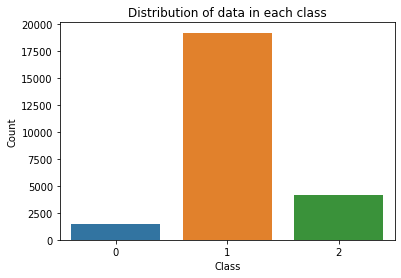

In [ ]:
plot(data)

In [ ]:
data=clean_text(data)
data['tweet'][1]

'      RT  boy dats cold   tyga dwn bad for cuffin dat hoe in the  st place  '

In [ ]:
X_train, y_train, X_test, y_test=split_data(data)
print("Length of train data: {}".format(X_train.shape[0]))
print("Length of test data: {}".format(X_test.shape[0]))

Length of train data: 21065
Length of test data: 3718


In [ ]:
max_words, token=create_token(X_train)
print("Vocabulary length: {}".format(max_words))

Vocabulary length: 18425


In [ ]:
train_pad=padding(token, X_train)
max_phrase=train_pad.shape[1]
print("Maximum length of a sentence: {}".format(max_phrase))

Maximum length of a sentence: 34


In [ ]:
model=LSTM_model(max_words, max_phrase)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 34, 256)           4717056   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 34, 256)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 5,308,931
Trainable params: 5,308,931
Non-trainable params: 0
______________________________________________

In [ ]:
model, hist=fit_model(model, train_pad)

Epoch 1/12
132/132 [==============================] - 26s 195ms/step - loss: 0.5010 - accuracy: 0.8216 - val_loss: 0.3515 - val_accuracy: 0.8785
Epoch 2/12
132/132 [==============================] - 25s 191ms/step - loss: 0.2617 - accuracy: 0.9109 - val_loss: 0.3047 - val_accuracy: 0.8880
Epoch 3/12
132/132 [==============================] - 26s 193ms/step - loss: 0.1801 - accuracy: 0.9382 - val_loss: 0.3497 - val_accuracy: 0.8837
Epoch 4/12
132/132 [==============================] - 25s 191ms/step - loss: 0.1312 - accuracy: 0.9557 - val_loss: 0.3902 - val_accuracy: 0.8766
Epoch 5/12
132/132 [==============================] - 25s 191ms/step - loss: 0.0947 - accuracy: 0.9667 - val_loss: 0.4535 - val_accuracy: 0.8756
Epoch 6/12
132/132 [==============================] - 25s 192ms/step - loss: 0.0792 - accuracy: 0.9728 - val_loss: 0.4634 - val_accuracy: 0.8711
Epoch 7/12
132/132 [==============================] - 25s 192ms/step - loss: 0.0658 - accuracy: 0.9767 - val_loss: 0.5409 - val_ac

ValueError: ignored

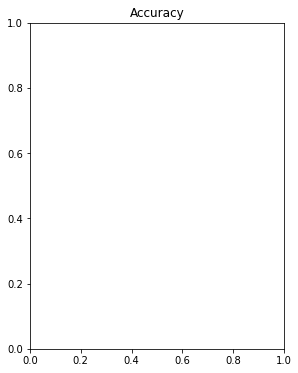

In [ ]:
plot_model(hist)

In [ ]:
test_sequences=token.texts_to_sequences(X_test)
test_pad=sequence.pad_sequences(test_sequences, maxlen=max_phrase)
print(test_pad.shape)

(3718, 34)


In [ ]:
y_pred = model.predict(test_pad)

In [ ]:
acc=model.evaluate(test_pad, y_test)

117/117 [==============================] - 1s 12ms/step - loss: 0.7007 - accuracy: 0.8757


In [ ]:
print("Accuracy: {}".format(acc[1]))

Accuracy: 0.8757396340370178
